<a href="https://colab.research.google.com/github/aakashpaul-2/RNN-Projects/blob/main/StockPrice_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Stock market forecasting using RNN
# Does well for a one step forecast (unrealistic case) but poor performance when it comes to multi step forecasting

In [ ]:
# imports
import torch
import torch.nn as nn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [ ]:
 series = df["close"].values.reshape(-1,1)

In [ ]:
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [ ]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
len(series) // 1.5

839.0

In [ ]:
len(series)

1259

In [ ]:
series

array([-1.62500489, -1.64174953, -1.6330132 , ...,  2.2342704 ,
        2.36822751,  2.20078112])

In [ ]:
T = 20
D = 1
X = []
Y = []

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.SHAPE", X.shape, "y.shape", Y.shape)

X.SHAPE (1239, 20, 1) y.shape (1239, 1)


In [ ]:
#AUTOREGRESSIVE RNN MODELS
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers,n_outputs):
    super(RNN,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs

    self.rnn = nn.LSTM(input_size=self.D, hidden_size=self.M, num_layers=self.L, batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self,X):
    h0 = torch.zeros(self.L, X.size(0),self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0),self.M).to(device)

    out,_ = self.rnn(X,(h0,c0))

    out = self.fc(out[:,-1,:])
    return out

In [ ]:
model = RNN(1,5,1,1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
      
    if (it + 1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
  
  return train_losses, test_losses

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.4298, Test Loss: 2.5906
Epoch 10/200, Train Loss: 0.1595, Test Loss: 0.6452
Epoch 15/200, Train Loss: 0.0746, Test Loss: 0.4478
Epoch 20/200, Train Loss: 0.0367, Test Loss: 0.4065
Epoch 25/200, Train Loss: 0.0160, Test Loss: 0.1915
Epoch 30/200, Train Loss: 0.0167, Test Loss: 0.1145
Epoch 35/200, Train Loss: 0.0108, Test Loss: 0.1103
Epoch 40/200, Train Loss: 0.0092, Test Loss: 0.0733
Epoch 45/200, Train Loss: 0.0082, Test Loss: 0.0703
Epoch 50/200, Train Loss: 0.0076, Test Loss: 0.0904
Epoch 55/200, Train Loss: 0.0068, Test Loss: 0.0640
Epoch 60/200, Train Loss: 0.0069, Test Loss: 0.0532
Epoch 65/200, Train Loss: 0.0065, Test Loss: 0.0609
Epoch 70/200, Train Loss: 0.0063, Test Loss: 0.0517
Epoch 75/200, Train Loss: 0.0063, Test Loss: 0.0487
Epoch 80/200, Train Loss: 0.0062, Test Loss: 0.0461
Epoch 85/200, Train Loss: 0.0061, Test Loss: 0.0431
Epoch 90/200, Train Loss: 0.0061, Test Loss: 0.0444
Epoch 95/200, Train Loss: 0.0060, Test Loss: 0.0421
Epoch 100/200

In [ ]:
#one step prediction
validation_target = Y
validation_predictions = []

i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(-1,T,1)
  p = model(input_)[0,0].item()
  i += 1


  validation_predictions.append(p)

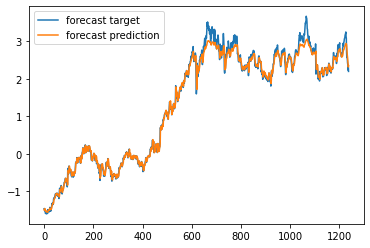

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# one step predictions are misleading - uses all previously available data to predict 1 step
# to forecast accuratly predictions must be made using the previously forecasted outcome, i.e. multistep

In [ ]:
X_test[0].view(T)

tensor([2.5677, 2.5910, 2.6449, 2.7250, 2.7060, 2.7439, 2.8181, 2.8633, 2.6041,
        2.5997, 2.4643, 2.4760, 2.4803, 2.5488, 2.5852, 2.6784, 2.6915, 2.6565,
        2.3973, 1.9649])

In [ ]:
p[0,0]

tensor(2.4328, grad_fn=<SelectBackward>)

In [ ]:
# multistep forcast

validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(-1,T,1)
  p = model(input_)
  

  validation_predictions.append(p[0,0].item())

  last_x = torch.cat((last_x[1:],p[0]))


In [ ]:
last_x[1:]

tensor([2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328,
        2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328,
        2.4328], grad_fn=<SliceBackward>)

In [ ]:
last_x

tensor([2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328,
        2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328, 2.4328,
        2.4328, 2.4328], grad_fn=<CatBackward>)

In [ ]:
p[0]

tensor([2.4328], grad_fn=<SelectBackward>)

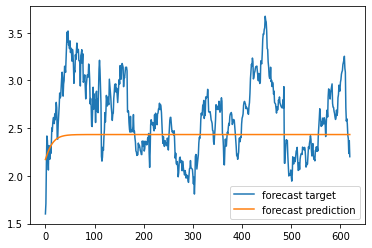

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# result here not as good!

In [ ]:
df["PrevClose"] = df["close"].shift(1)

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
# Try forecasting the returns per day instead
df["Return"] = (df["close"] - df["PrevClose"] )/ df["PrevClose"]

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


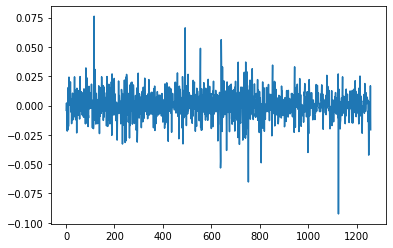

In [ ]:
df["Return"].plot()

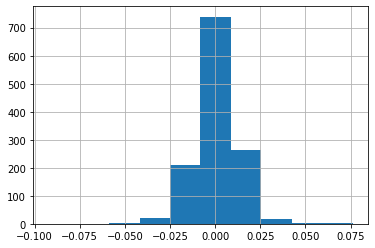

In [ ]:
df["Return"].hist()

In [ ]:
series = df["Return"].values[1:].reshape(-1,1)

In [ ]:
series

array([-0.43811722,  0.08061497, -0.73536414, ..., -1.71332483,
        1.30572463, -1.82299002])

In [ ]:
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()


In [ ]:
T = 20
D = 1
X = []
Y = []

for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.SHAPE", X.shape, "y.shape", Y.shape)

X.SHAPE (1238, 20, 1) y.shape (1238, 1)


In [ ]:
model = RNN(1,5,1,1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 1.0504, Test Loss: 1.0707
Epoch 10/200, Train Loss: 1.0431, Test Loss: 1.0796
Epoch 15/200, Train Loss: 1.0313, Test Loss: 1.1053
Epoch 20/200, Train Loss: 1.0185, Test Loss: 1.1022
Epoch 25/200, Train Loss: 1.0034, Test Loss: 1.1134
Epoch 30/200, Train Loss: 0.9897, Test Loss: 1.1425
Epoch 35/200, Train Loss: 0.9716, Test Loss: 1.1853
Epoch 40/200, Train Loss: 0.9567, Test Loss: 1.2385
Epoch 45/200, Train Loss: 0.9252, Test Loss: 1.2487
Epoch 50/200, Train Loss: 0.9145, Test Loss: 1.2927
Epoch 55/200, Train Loss: 0.8859, Test Loss: 1.3719
Epoch 60/200, Train Loss: 0.8608, Test Loss: 1.4248
Epoch 65/200, Train Loss: 0.8484, Test Loss: 1.4558
Epoch 70/200, Train Loss: 0.8103, Test Loss: 1.4985
Epoch 75/200, Train Loss: 0.7882, Test Loss: 1.5872
Epoch 80/200, Train Loss: 0.7674, Test Loss: 1.6328
Epoch 85/200, Train Loss: 0.7488, Test Loss: 1.6711
Epoch 90/200, Train Loss: 0.7785, Test Loss: 1.7158
Epoch 95/200, Train Loss: 0.7609, Test Loss: 1.7120
Epoch 100/200

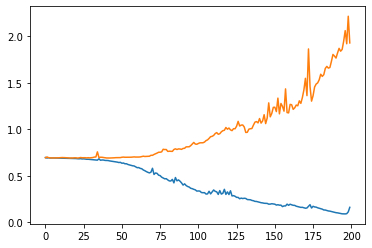

In [ ]:
plt.plot(train_losses)
plt.plot(test_losses)

In [ ]:
#one step prediction
validation_target = Y
validation_predictions = []

i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(-1,T,1)
  p = model(input_)[0,0].item()
  i += 1


  validation_predictions.append(p)

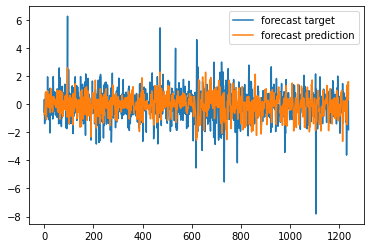

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# again one step forecast is OK

In [ ]:
# multistep forcast

validation_target = Y[-N//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(-1,T,1)
  p = model(input_)
  

  validation_predictions.append(p[0,0].item())

  last_x = torch.cat((last_x[1:],p[0]))


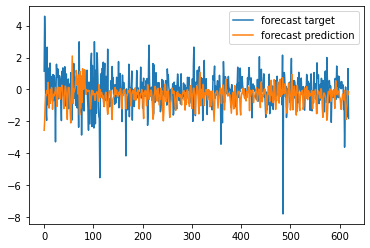

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
# Multi step not as good again
# stock forecast just based on previous data does not yield the best results!

In [ ]:
input_data = df[["open","high","low","close","volume"]].values
targets = df["Return"].values

In [ ]:
T = 10
D = input_data.shape[1]
N  = len(input_data) - T

In [ ]:
Ntrain = len(input_data) * 2//3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
X_train = np.zeros((Ntrain, T , D))
y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  y_train[t] = (targets[t+T] > 0 )



In [ ]:
X_train.shape

(839, 10, 5)

In [ ]:
X_test = np.zeros((N - Ntrain, T , D))
y_test = np.zeros((N- Ntrain, 1))

for u in range(N-Ntrain):
  t = u + Ntrain
  X_test[u,:,:] = input_data[t:t+T]
  y_test[u] = (targets[t+T] > 0 )


In [ ]:
model = RNN(5,50,2,1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.6921, Test Loss: 0.6928
Epoch 10/200, Train Loss: 0.6912, Test Loss: 0.6950
Epoch 15/200, Train Loss: 0.6898, Test Loss: 0.6940
Epoch 20/200, Train Loss: 0.6867, Test Loss: 0.6944
Epoch 25/200, Train Loss: 0.6820, Test Loss: 0.6950
Epoch 30/200, Train Loss: 0.6771, Test Loss: 0.6935
Epoch 35/200, Train Loss: 0.6689, Test Loss: 0.7581
Epoch 40/200, Train Loss: 0.6662, Test Loss: 0.6942
Epoch 45/200, Train Loss: 0.6563, Test Loss: 0.6932
Epoch 50/200, Train Loss: 0.6456, Test Loss: 0.6965
Epoch 55/200, Train Loss: 0.6221, Test Loss: 0.7009
Epoch 60/200, Train Loss: 0.5979, Test Loss: 0.7024
Epoch 65/200, Train Loss: 0.5636, Test Loss: 0.7115
Epoch 70/200, Train Loss: 0.5397, Test Loss: 0.7213
Epoch 75/200, Train Loss: 0.5079, Test Loss: 0.7539
Epoch 80/200, Train Loss: 0.4700, Test Loss: 0.7836
Epoch 85/200, Train Loss: 0.4251, Test Loss: 0.7835
Epoch 90/200, Train Loss: 0.4247, Test Loss: 0.7849
Epoch 95/200, Train Loss: 0.3801, Test Loss: 0.8127
Epoch 100/200

In [ ]:
#AUTOREGRESSIVE RNN MODELS
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers,n_outputs):
    super(RNN,self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs

    self.rnn = nn.LSTM(input_size=self.D, hidden_size=self.M, num_layers=self.L, batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self,X):
    h0 = torch.zeros(self.L, X.size(0),self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0),self.M).to(device)

    out,_ = self.rnn(X,(h0,c0))

    out = self.fc(out[:,-1,:])
    return out

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)